<a href="https://colab.research.google.com/github/Ken-huea/Language-processing/blob/main/%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86_%E3%82%AB%E3%83%86%E3%82%B4%E3%83%AA%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実装

## データベースの作成
データベースの作成 ⇒ RNN迄の下準備

### データ読込と確認

In [3]:
import pandas as pd

Tweet = pd.read_csv('./6020_negative_positive_data/data/Airline-Sentiment-2-w-AA.csv', encoding='cp932')

# データの読込　今回は3000までのデータ読み込みを行います。
tweetData = Tweet.loc[:3000,['text', 'airline_sentiment']]
tweetData = pd.DataFrame(tweetData)

In [4]:
# これが元データ
Tweet.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,...,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,...,NaN,2/24/15 11:35,5.70E+17,NaN,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,NaN
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0,Virgin America,...,NaN,2/24/15 11:15,5.70E+17,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,...,NaN,2/24/15 11:15,5.70E+17,Lets Play,Central Time (US & Canada),NaN,NaN,NaN,NaN,NaN


これが今回インポートしたデータ。テキストと airline_sentiment があります。

airline_sentimentは<font color="red">positive / negative / neutral</font>があります。文章による傾向の事ですね。

In [5]:
tweetData.head(3) 

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


### データの余計な部分を抽出。
使える必要な要素のみ残す。

RNNは単語の関連性を分析するので ⇒ <font color="red">Iやwhatなど</font>頻出する単語は削除する。
Googleの検索エンジンでも同様の処理を行っている。

In [6]:
# 単なるデータのインポート
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords

# エラーが出たら↓をコメントアウトしてください
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# 取得データの確認。
tweetData.head(4)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative


In [8]:
# このコードの解釈。 小文字大文字のa-zと@は残ります。それ以外は[空欄]になります。例えば ' 数字2456 --- 等が空欄になる。　^　これが打消。　打消 小文字大文字のa-zと@ 以外。
letters_only = re.sub("[^a-zA-Z@]", " ",tweetData["text"][2]) 

In [9]:
# 英語Tweetの形態素解析を行います
def tweet_to_words(raw_tweet):
    
    # a~zまで始まる単語を空白ごとに区切ったリストをつくります  　re.subは置換のメソッド。raw_twwwtをどのように置換しているの？
    letters_only = re.sub("[^a-zA-Z@]", " ",raw_tweet)          # 上のコードにて説明
    words = letters_only.lower().split()                        # splitして大文字を全て小文字に変換している。

    
    # '@'と'flight'が含まれる文字とストップワードを削除 ⇒ 頻出する単語として削除する ⇒ どこでストップワードを定義したのですか？
    stops = set(stopwords.words("english")) 
    # wの要素を一つづつ抽出しfor文で回す。そしてif文で条件分岐。 stop wordsだったら間引いている。という事？
    meaningful_words = [w for w in words if not w in stops and not re.match("^[@]", w) and not re.match("flight",w)]
   
     
    return( " ".join( meaningful_words )) 

- a for a in words if not a in stops でwordsリストに入っている単語とstopsリストに被っているものを除きます
- not re.match("^[文字列]", a) で指定した文字列を含む単語を除きます
- not a in stops and not re.match and not re.match で複数の条件を表すことができます

`meaningful_words = [w for w in words if not w in stops and not re.match("^[@]", w) and not re.match("flight",w)]`

最初の w は無視する。wordsから一つづつ持ってきて、wに格納する。そのwをif文で検査している。

① wがstopsの中に該当しない

② wの中に@やflightが入っていないか。("^[@]", w) wの内容を検査する。


```
w for w in words
if not w in stops and 
not re.match("^[@]", w) and 
not re.match("flight",w)
```
flight ＠ stopでも該当しないワードのみを残します。

これにより、①数値や余計な記号が消えました。　②意味のある言葉のみ抽出出来ました。(stop_words)

In [10]:
# 処理を行い表示。 これはtweetDataのカラム['text']に対して、独自関数を掛けていますよ。という事。　airline_sentimentはここでドロップ。

cleanTweet = tweetData['text'].apply(lambda x: tweet_to_words(x))
df_cleanTweet = pd.DataFrame(cleanTweet)
df_cleanTweet.head(5)

# 処理後 

,text
0,said
1,plus added commercials experience tacky
2,today must mean need take another trip
3,really aggressive blast obnoxious entertainmen...
4,really big bad thing


処理前と処理後の結果を調べてみ観ると、
処理後は<font color="red">重要な単語</font>のみ残されている。⇒勝手が良くなった。



In [11]:
# 処理前
tweetData.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### 厳選された情報(df)を一つのリスト変数に変換する。
[このセクション](https://premium.aidemy.jp/courses/6020/exercises/wYLfJKc9sE)　も意味わからん

In [12]:
df_cleanTweet.head(3)

,text
0,said
1,plus added commercials experience tacky
2,today must mean need take another trip


前セクションで上記のように意味のある単語のみ抽出してdfにすることが出来ました。

このままでは文字列なので、<font color="red">数値に変換する処理</font>を行っていこうと思います。

In [13]:
# ① dfを全てつなげてみましょう。全摘出して変数に格納します。
all_text = ' '.join(cleanTweet)
all_text

'said plus added commercials experience tacky today must mean need take another trip really aggressive blast obnoxious entertainment guests faces amp little recourse really big bad thing seriously would pay seats playing really bad thing flying va yes nearly every time fly vx ear worm go away really missed prime opportunity men without hats parody https co mwpg grezp well amazing arrived hour early good know suicide second leading cause death among teens lt pretty graphics much better minimal iconography great deal already thinking nd trip amp even gone st trip yet p flying fabulous seductive skies u take stress away travel http co ahlxhhkiyn thanks sfo pdx schedule still mia excited first cross country lax mco heard nothing great things virgin america daystogo flew nyc sfo last week fully sit seat due two large gentleman either side help flying know would amazingly awesome bos fll please want fly first fares may three times carriers seats available select love graphic http co ut grrwa

In [14]:
# ② その後にその繋げた内容を「半角スペース」で区切ってリスト化する。　⇒　分かち書きみたいな結果になりますね。
words = all_text.split()
print(words)              # これで必要な単語が全てリストに入りました。

print(len(words))

['said', 'plus', 'added', 'commercials', 'experience', 'tacky', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse', 'really', 'big', 'bad', 'thing', 'seriously', 'would', 'pay', 'seats', 'playing', 'really', 'bad', 'thing', 'flying', 'va', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'ear', 'worm', 'go', 'away', 'really', 'missed', 'prime', 'opportunity', 'men', 'without', 'hats', 'parody', 'https', 'co', 'mwpg', 'grezp', 'well', 'amazing', 'arrived', 'hour', 'early', 'good', 'know', 'suicide', 'second', 'leading', 'cause', 'death', 'among', 'teens', 'lt', 'pretty', 'graphics', 'much', 'better', 'minimal', 'iconography', 'great', 'deal', 'already', 'thinking', 'nd', 'trip', 'amp', 'even', 'gone', 'st', 'trip', 'yet', 'p', 'flying', 'fabulous', 'seductive', 'skies', 'u', 'take', 'stress', 'away', 'travel', 'http', 'co', 'ahlxhhkiyn', 'thanks', 'sfo', 'pdx', 'schedule'

### その文字列情報に数値として価値を付与する。
今回はその単語の頻出度合いにより番号を付けたいと思います。「文字列に番号を付与して数値化」
[こちら](https://premium.aidemy.jp/courses/6020/exercises/lTu_48yg9T)

あれ？

In [15]:
print(words)

['said', 'plus', 'added', 'commercials', 'experience', 'tacky', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse', 'really', 'big', 'bad', 'thing', 'seriously', 'would', 'pay', 'seats', 'playing', 'really', 'bad', 'thing', 'flying', 'va', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'ear', 'worm', 'go', 'away', 'really', 'missed', 'prime', 'opportunity', 'men', 'without', 'hats', 'parody', 'https', 'co', 'mwpg', 'grezp', 'well', 'amazing', 'arrived', 'hour', 'early', 'good', 'know', 'suicide', 'second', 'leading', 'cause', 'death', 'among', 'teens', 'lt', 'pretty', 'graphics', 'much', 'better', 'minimal', 'iconography', 'great', 'deal', 'already', 'thinking', 'nd', 'trip', 'amp', 'even', 'gone', 'st', 'trip', 'yet', 'p', 'flying', 'fabulous', 'seductive', 'skies', 'u', 'take', 'stress', 'away', 'travel', 'http', 'co', 'ahlxhhkiyn', 'thanks', 'sfo', 'pdx', 'schedule'

In [16]:
from collections import Counter
# 単語の出現回数をカウントします 
counts = Counter(words)
print(len(counts)) # 422 ⇒ 327  ダブりが除去されてユニーク値のみ という事ですね。

print(counts)

5218
Counter({'get': 249, 'co': 245, 'http': 233, 'service': 209, 'thanks': 196, 'ua': 171, 'time': 170, 'help': 168, 'customer': 166, 'united': 166, 'cancelled': 160, 'bag': 148, 'plane': 140, 'gate': 128, 'amp': 127, 'would': 126, 'delayed': 126, 'one': 122, 'thank': 121, 'still': 117, 'us': 116, 'hours': 114, 'airline': 105, 'need': 103, 'like': 103, 'back': 102, 'late': 100, 'please': 99, 'hour': 90, 'check': 88, 'fly': 84, 'seat': 84, 'dm': 81, 'got': 77, 'today': 76, 'u': 76, 'last': 75, 'first': 73, 'let': 73, 'wait': 73, 'way': 72, 'never': 72, 'lost': 72, 'luggage': 72, 'day': 71, 'airport': 70, 'waiting': 70, 'flying': 69, 'know': 69, 'sfo': 69, 'ticket': 69, 'trying': 69, 'people': 69, 'delay': 68, 'baggage': 67, 'really': 65, 'bags': 65, 'guys': 64, 'ever': 64, 'going': 64, 'another': 63, 'worst': 63, 'make': 63, 'see': 62, 'seats': 60, 'due': 60, 'home': 60, 'good': 59, 'lax': 58, 'yes': 57, 'go': 57, 'hrs': 57, 'great': 56, 'even': 56, 'agent': 56, 'next': 55, 'new': 55, 

ランキングの付け方なのですが、基準として<font color="red"> key=counts.get</font>としています。<font color="red">上のcountsのvalueの値を基準</font>として順位付けを行っています。

In [17]:
# sort変数を用いて順番を並び替えます。今回は多い順に。reverse=True で

vocab = sorted(counts, key=counts.get, reverse=True)

print(vocab)
# きっとcoが9なので一番多い。

['get', 'co', 'http', 'service', 'thanks', 'ua', 'time', 'help', 'customer', 'united', 'cancelled', 'bag', 'plane', 'gate', 'amp', 'would', 'delayed', 'one', 'thank', 'still', 'us', 'hours', 'airline', 'need', 'like', 'back', 'late', 'please', 'hour', 'check', 'fly', 'seat', 'dm', 'got', 'today', 'u', 'last', 'first', 'let', 'wait', 'way', 'never', 'lost', 'luggage', 'day', 'airport', 'waiting', 'flying', 'know', 'sfo', 'ticket', 'trying', 'people', 'delay', 'baggage', 'really', 'bags', 'guys', 'ever', 'going', 'another', 'worst', 'make', 'see', 'seats', 'due', 'home', 'good', 'lax', 'yes', 'go', 'hrs', 'great', 'even', 'agent', 'next', 'new', 'min', 'w', 'ord', 'experience', 'problems', 'number', 'ewr', 'minutes', 'crew', 'told', 'tomorrow', 'change', 'take', 'two', 'staff', 'email', 'sent', 'miss', 'phone', 'trip', 'could', 'hold', 'call', 'website', 'days', 'getting', 'boarding', 'care', 'left', 'much', 'love', 'booked', 'better', 'issue', 'made', 'iad', 'book', 'someone', 'sure', '

In [18]:
# vocabからインデックスと要素を取り出す。 ii⇒index word 要素 が入る。　enumurateの「１」は0ではなく、1から取り出すよ。という事。

# 辞書化する。 {word: ii ここで辞書にしている。⇒ wordがkey(co)     iiがvalue(1)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

print(vocab_to_int)

{'get': 1, 'co': 2, 'http': 3, 'service': 4, 'thanks': 5, 'ua': 6, 'time': 7, 'help': 8, 'customer': 9, 'united': 10, 'cancelled': 11, 'bag': 12, 'plane': 13, 'gate': 14, 'amp': 15, 'would': 16, 'delayed': 17, 'one': 18, 'thank': 19, 'still': 20, 'us': 21, 'hours': 22, 'airline': 23, 'need': 24, 'like': 25, 'back': 26, 'late': 27, 'please': 28, 'hour': 29, 'check': 30, 'fly': 31, 'seat': 32, 'dm': 33, 'got': 34, 'today': 35, 'u': 36, 'last': 37, 'first': 38, 'let': 39, 'wait': 40, 'way': 41, 'never': 42, 'lost': 43, 'luggage': 44, 'day': 45, 'airport': 46, 'waiting': 47, 'flying': 48, 'know': 49, 'sfo': 50, 'ticket': 51, 'trying': 52, 'people': 53, 'delay': 54, 'baggage': 55, 'really': 56, 'bags': 57, 'guys': 58, 'ever': 59, 'going': 60, 'another': 61, 'worst': 62, 'make': 63, 'see': 64, 'seats': 65, 'due': 66, 'home': 67, 'good': 68, 'lax': 69, 'yes': 70, 'go': 71, 'hrs': 72, 'great': 73, 'even': 74, 'agent': 75, 'next': 76, 'new': 77, 'min': 78, 'w': 79, 'ord': 80, 'experience': 81, 

vocab_to_intに文字と頻出ランキングを辞書型に格納しましたよね。それと words を組み合わせます。

ここで<font color="red">文字列を数値として変換</font>をしています。

eachには最初saidが入る。 だから`vocab_to_int[said] ` でvocab_to_intのvalueとなる。　これをappendしている。

In [19]:
print(cleanTweet)
print()
print(words)

0                                                    said
1                 plus added commercials experience tacky
2                  today must mean need take another trip
3       really aggressive blast obnoxious entertainmen...
4                                    really big bad thing
                              ...                        
2996    https co jpd nsgrt fyi staff telling customers...
2997    possibly messed trip anymore thanks terrible a...
2998    wifi ua sf chicago ps tech intro video joke ep...
2999                                                  thx
3000    based suggestions passengers rental car standb...
Name: text, Length: 3001, dtype: object

['said', 'plus', 'added', 'commercials', 'experience', 'tacky', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse', 'really', 'big', 'bad', 'thing', 'seriously', 'would', 'pay', 'seats', 'playing', 'rea

① cleanTweetから一つづつ取ってくる。

② その取り出された要素を空欄で区切る`.split()`それをwordに格納。

③そのwordがvocab_to_intのkeyとなりvalue(数値)が取り出される。

In [20]:
# これは辞書型の知識と理解が必要だ。
[vocab_to_int['said']]               # 返り値[56]
[vocab_to_int['plus']]               # 返り値[57]

[238]

In [21]:
# 新しいリストに文字列を数値化したものを格納します
tweet_ints = []
for each in cleanTweet:
    tweet_ints.append([vocab_to_int[word] for word in each.split()]) #　スペースで区切る

print(tweet_ints)

[[168], [238, 654, 2321, 81, 2322], [35, 524, 351, 24, 90, 61, 97], [56, 1560, 2323, 2324, 395, 2325, 2326, 15, 370, 1561], [56, 396, 161, 319], [249, 16, 192, 65, 1211, 56, 161, 319, 48, 655], [70, 848, 182, 7, 31, 371, 2327, 2328, 71, 291], [56, 127, 1562, 1009, 1563, 250, 2329, 2330, 423, 2, 2331, 2332], [154], [207, 263, 29, 196, 68], [49, 2333, 334, 2334, 525, 1564, 1565, 2335], [526, 424, 2336, 107, 110, 2337, 2338], [73, 372, 163, 1566, 488, 97, 15, 74, 729, 173, 97, 164, 730], [48, 1567, 2339, 1568, 36, 90, 1569, 291, 134, 3, 2, 2340], [5], [50, 656, 657, 20, 658], [731, 38, 659, 489, 69, 584, 397, 183, 73, 660, 239, 661, 2341], [453, 425, 50, 37, 138, 1212, 335, 32, 66, 91, 1570, 2342, 490, 1571, 8], [48], [49, 16, 2343, 213, 373, 585, 28, 117, 31], [38, 586, 197, 336, 135, 1010, 65, 198, 1011], [108, 2344, 3, 2, 1572, 2345], [108, 2346, 1573, 527, 68, 1574], [208, 373, 222, 264, 374, 352, 2347, 732, 353], [58, 1012, 528, 1575, 528, 733, 58, 292, 32, 291, 117, 184, 1013], [136

In [22]:
tweet_ints

[[168],
 [238, 654, 2321, 81, 2322],
 [35, 524, 351, 24, 90, 61, 97],
 [56, 1560, 2323, 2324, 395, 2325, 2326, 15, 370, 1561],
 [56, 396, 161, 319],
 [249, 16, 192, 65, 1211, 56, 161, 319, 48, 655],
 [70, 848, 182, 7, 31, 371, 2327, 2328, 71, 291],
 [56, 127, 1562, 1009, 1563, 250, 2329, 2330, 423, 2, 2331, 2332],
 [154],
 [207, 263, 29, 196, 68],
 [49, 2333, 334, 2334, 525, 1564, 1565, 2335],
 [526, 424, 2336, 107, 110, 2337, 2338],
 [73, 372, 163, 1566, 488, 97, 15, 74, 729, 173, 97, 164, 730],
 [48, 1567, 2339, 1568, 36, 90, 1569, 291, 134, 3, 2, 2340],
 [5],
 [50, 656, 657, 20, 658],
 [731, 38, 659, 489, 69, 584, 397, 183, 73, 660, 239, 661, 2341],
 [453, 425, 50, 37, 138, 1212, 335, 32, 66, 91, 1570, 2342, 490, 1571, 8],
 [48],
 [49, 16, 2343, 213, 373, 585, 28, 117, 31],
 [38, 586, 197, 336, 135, 1010, 65, 198, 1011],
 [108, 2344, 3, 2, 1572, 2345],
 [108, 2346, 1573, 527, 68, 1574],
 [208, 373, 222, 264, 374, 352, 2347, 732, 353],
 [58, 1012, 528, 1575, 528, 733, 58, 292, 32, 29

### 例外処理を行います。
[こちら](https://premium.aidemy.jp/courses/6020/exercises/wAqlm5gP_cD)
⇒　間引きによって何も残らなかった場合を考える。
　<font color="red">バグ？</font>。動画の30分辺り。

In [23]:
# 単語を数値に置き換えたもの。⇒これがおかしくなっている。
print(tweet_ints)
tweet_ints

[[168], [238, 654, 2321, 81, 2322], [35, 524, 351, 24, 90, 61, 97], [56, 1560, 2323, 2324, 395, 2325, 2326, 15, 370, 1561], [56, 396, 161, 319], [249, 16, 192, 65, 1211, 56, 161, 319, 48, 655], [70, 848, 182, 7, 31, 371, 2327, 2328, 71, 291], [56, 127, 1562, 1009, 1563, 250, 2329, 2330, 423, 2, 2331, 2332], [154], [207, 263, 29, 196, 68], [49, 2333, 334, 2334, 525, 1564, 1565, 2335], [526, 424, 2336, 107, 110, 2337, 2338], [73, 372, 163, 1566, 488, 97, 15, 74, 729, 173, 97, 164, 730], [48, 1567, 2339, 1568, 36, 90, 1569, 291, 134, 3, 2, 2340], [5], [50, 656, 657, 20, 658], [731, 38, 659, 489, 69, 584, 397, 183, 73, 660, 239, 661, 2341], [453, 425, 50, 37, 138, 1212, 335, 32, 66, 91, 1570, 2342, 490, 1571, 8], [48], [49, 16, 2343, 213, 373, 585, 28, 117, 31], [38, 586, 197, 336, 135, 1010, 65, 198, 1011], [108, 2344, 3, 2, 1572, 2345], [108, 2346, 1573, 527, 68, 1574], [208, 373, 222, 264, 374, 352, 2347, 732, 353], [58, 1012, 528, 1575, 528, 733, 58, 292, 32, 291, 117, 184, 1013], [136

[[168],
 [238, 654, 2321, 81, 2322],
 [35, 524, 351, 24, 90, 61, 97],
 [56, 1560, 2323, 2324, 395, 2325, 2326, 15, 370, 1561],
 [56, 396, 161, 319],
 [249, 16, 192, 65, 1211, 56, 161, 319, 48, 655],
 [70, 848, 182, 7, 31, 371, 2327, 2328, 71, 291],
 [56, 127, 1562, 1009, 1563, 250, 2329, 2330, 423, 2, 2331, 2332],
 [154],
 [207, 263, 29, 196, 68],
 [49, 2333, 334, 2334, 525, 1564, 1565, 2335],
 [526, 424, 2336, 107, 110, 2337, 2338],
 [73, 372, 163, 1566, 488, 97, 15, 74, 729, 173, 97, 164, 730],
 [48, 1567, 2339, 1568, 36, 90, 1569, 291, 134, 3, 2, 2340],
 [5],
 [50, 656, 657, 20, 658],
 [731, 38, 659, 489, 69, 584, 397, 183, 73, 660, 239, 661, 2341],
 [453, 425, 50, 37, 138, 1212, 335, 32, 66, 91, 1570, 2342, 490, 1571, 8],
 [48],
 [49, 16, 2343, 213, 373, 585, 28, 117, 31],
 [38, 586, 197, 336, 135, 1010, 65, 198, 1011],
 [108, 2344, 3, 2, 1572, 2345],
 [108, 2346, 1573, 527, 68, 1574],
 [208, 373, 222, 264, 374, 352, 2347, 732, 353],
 [58, 1012, 528, 1575, 528, 733, 58, 292, 32, 29

In [24]:
# 各行の長さを見ています。
tweet_len = Counter([len(x) for x in tweet_ints])
print("tweet_len:",tweet_len)                         # 9単語が7個 10単語が6個...という事。　上の変数のリスト塊ずつカウントされますので。

seq_len = max(tweet_len)
print("seq_len:",seq_len)                             # 最大は16単語です。と。ここがおかしい。

print("Zero-length reviews: {}".format(tweet_len[0])) # 何もない、というのはない。
print("Maximum review length: {}".format(max(tweet_len)))

# これがどんな意味を指し示すのか？

tweet_len: Counter({10: 319, 11: 313, 12: 275, 8: 270, 9: 246, 7: 210, 13: 199, 6: 195, 5: 171, 4: 156, 14: 137, 3: 127, 2: 106, 1: 96, 15: 86, 16: 50, 17: 29, 18: 5, 0: 3, 19: 3, 20: 2, 43: 1, 40: 1, 107: 1})
seq_len: 107
Zero-length reviews: 3
Maximum review length: 107


これは何のために行ったのか？というと、｢間引き｣によって全ての情報が間引かれてしまった場合の処理。

In [25]:
# cleanTweetで0文字になってしまった行を削除します　len(tweet)が0以上であれば
tweet_idx  = [idx for idx,tweet in enumerate(tweet_ints) if len(tweet) > 0]
print(tweet_idx)             # 0 の場合は値が抜け落ちるものだけど、今回は全て最低1語以上あります。

# labels = labels[tweet_idx]
# print(labels)
tweet_ints = [tweet for tweet in tweet_ints if len(tweet) > 0]
print(tweet_ints)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### ラベル['airline_sentiment'] の処理を考える。
[こちら](https://premium.aidemy.jp/courses/6020/exercises/zBy3UhTcl57)

ネガティブ=0, ポジティブ=1, ニュートラル=2に変換してdfに再格納。例外処理も踏まえた上で。

ネガティブポジティブを司る、airline_sentimentのみを抽出。 ⇒ これが<font color="red">ラベル</font>になります。

`np.array([0 if each == 'negative' else 1 if each == 'positive' else 2 for each in tweetData['airline_sentiment']]) `

tweetData['airline_sentiment']の変数eachに格納。　そしてeachを == で場合分け。

In [26]:
# こちらの airline_sentiment この分類がラベルになります。
tweetData.head(3)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


まずはpositive negative neutral を数値で場合分けしてみましょう。<font color="red">negativeを0, positiveを1,neutralを2</font>に。

In [28]:
# Tweetのnegative/positiveの文字列を数字に変換します.tweetData['airline_sentiment']全部変換。
labels = np.array([0 if each == 'negative' else 1 if each == 'positive' else 2 for each in tweetData['airline_sentiment'][:]]) 

In [40]:
# tweet_idxは要素0が抜け落ちたから特徴量。?このコードで上手く行く。
labels = labels[tweet_idx]

In [41]:
# 上記のコードの説明。リストの仕組みを再確認。
# labels[["数値"]] により、そのラベルの要素の中から好きな場所(index)から値を取得する事が可能です。

# 例えばこれ。これはlabelsのindex番号4,5,6の値を取得しています。」という事。⇒ array([0, 0, 1])
labels[[4,5,6]]

# 今回は[[]]の中に直接 tweet_idx を格納しているという訳ですね。

array([0, 0, 1])

In [63]:
from keras.utils.np_utils import to_categorical
# ちゃんとカテゴリカル変数化もしておきましょう。
labels = to_categorical(labels, 3)
labels = pd.DataFrame(labels)
labels.head(3)

,0,1,2
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [64]:
len(labels)

2998

### 数値化した単語をdfに変換。
こんなコード自力で書ける気がしない。

何も入っていない状態はnp.zerosである。0が行*列。　
そこにそれぞれの単語数を右詰めに代入します。

例えば iに0が入り,rowに[56]が格納されます。 要素数１です。

` features[i, -len(row):] = np.array(row)`　-len(row):はlenで要素数１。つまり<font color="red">-1:</font>　一番右の要素。　そこに56が格納されます。

In [65]:
# i行ごとの数値化した単語を右から書いたフレームワークを作ります。他の数字は0にします。
features = np.zeros((len(tweet_ints), seq_len), dtype=int)
for i, row in enumerate(tweet_ints):
  features[i, -len(row):] = np.array(row)

features = pd.DataFrame(features)
features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,168
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,238,654,2321,81,2322
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,35,524,351,24,90,61,97
3,0,0,0,0,0,0,0,0,0,0,...,56,1560,2323,2324,395,2325,2326,15,370,1561
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,56,396,161,319


In [66]:
print(seq_len)          # 最大の文字数
print(tweet_ints)
print(len(tweet_ints))  # 要素数
print(len(features))
print(len(labels))      # 34の部分を抜かなければならない。4

107
[[168], [238, 654, 2321, 81, 2322], [35, 524, 351, 24, 90, 61, 97], [56, 1560, 2323, 2324, 395, 2325, 2326, 15, 370, 1561], [56, 396, 161, 319], [249, 16, 192, 65, 1211, 56, 161, 319, 48, 655], [70, 848, 182, 7, 31, 371, 2327, 2328, 71, 291], [56, 127, 1562, 1009, 1563, 250, 2329, 2330, 423, 2, 2331, 2332], [154], [207, 263, 29, 196, 68], [49, 2333, 334, 2334, 525, 1564, 1565, 2335], [526, 424, 2336, 107, 110, 2337, 2338], [73, 372, 163, 1566, 488, 97, 15, 74, 729, 173, 97, 164, 730], [48, 1567, 2339, 1568, 36, 90, 1569, 291, 134, 3, 2, 2340], [5], [50, 656, 657, 20, 658], [731, 38, 659, 489, 69, 584, 397, 183, 73, 660, 239, 661, 2341], [453, 425, 50, 37, 138, 1212, 335, 32, 66, 91, 1570, 2342, 490, 1571, 8], [48], [49, 16, 2343, 213, 373, 585, 28, 117, 31], [38, 586, 197, 336, 135, 1010, 65, 198, 1011], [108, 2344, 3, 2, 1572, 2345], [108, 2346, 1573, 527, 68, 1574], [208, 373, 222, 264, 374, 352, 2347, 732, 353], [58, 1012, 528, 1575, 528, 733, 58, 292, 32, 291, 117, 184, 1013], 

## LSTM の学習

### LSTM
[こちら](https://premium.aidemy.jp/courses/6020/exercises/5TMXDN532or)

In [67]:
# featuresを元にLSTMモデルの作成を行う。
print(features.shape) # (2998, 107)
print(labels.shape)   # (3001, 3)


(2998, 107)
(2998, 3)


In [68]:
from sklearn.model_selection import train_test_split
train_x , test_x,train_y,test_y = train_test_split(features,labels, random_state=0)
print(train_x.shape , test_x.shape,train_y.shape,test_y.shape)


(2248, 107) (750, 107) (2248, 3) (750, 3)


元のデータ概要が不明なのでどの意図をもって、どんなふうにreshapeしたか分からないけど、とにかくLSTM用にreshapeしている。

`lstm_model.input_shape # 入力層の確認 ⇒ (None, 1, 107)`

In [69]:
# 学習データを(サンプル数, シーケンス長, 次元数) の形に変換する
train_x = np.reshape(train_x.values,(train_x.shape[0], 1,train_x.shape[1]))
test_x = np.reshape(test_x.values,(test_x.shape[0], 1 ,test_x.shape[1]))


# 表示
print(train_x.shape,test_x.shape,)  # (10920, 1, 107) (3641, 1, 107)
print(test_x.shape,test_y.shape)    # (3641, 1, 107) (3641, 3)

(2248, 1, 107) (750, 1, 107)
(750, 1, 107) (750, 3)


#### 学習
[教材はこちら](https://premium.aidemy.jp/courses/6020/exercises/z6LNp0VK9Ah)

[optimizer](https://qiita.com/tokkuman/items/33c66fcff7337a1c0fa8)

In [70]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
lstm_model.add(LSTM(units=32, return_sequences=False))
lstm_model.add(Dense(units=3,activation='softmax'))
lstm_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
# lstm_model = Sequential()

# lstm_model.add(LSTM(units=64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))  ## lstm_model.add(LSTM(units=60, input_dim=train_x.shape[2], input_length=train_x.shape[1], return_sequences=True))
# # lstm_model.add(LSTM(units=64, return_sequences=True))
# lstm_model.add(LSTM(units=32, return_sequences=False)) # 最後のみfalse
# lstm_model.add(Dense(units=3,activation='softmax'))    # 2softmax relu

# lstm_model.compile(       
#               loss='categorical_crossentropy', # 損失関数を指定してください。
#               optimizer='AdaDelta',                # オプティマイザーを指定してください。 rmsprop
#               metrics=['accuracy'])            # 評価関数を指定してください。

lstm_model.summary()

# この通りモデルが貧弱なのだが、どのようにすれば精度向上するのかピンと来ない。

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             44032     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 56,547
Trainable params: 56,547
Non-trainable params: 0
_________________________________________________________________


In [72]:
lstm_model.input_shape # 入力層の確認 ⇒ (None, 1, 107)

(None, 1, 107)

In [73]:
# 表示
print(train_x.shape,test_x.shape,)  # (10920, 1, 107) (3641, 1, 107)
print(test_x.shape,test_y.shape)    # (3641, 1, 107) (3641, 3)

(2248, 1, 107) (750, 1, 107)
(750, 1, 107) (750, 3)


In [74]:
# ハイパーパラメータ
batch_size = 128  # バッチサイズ 32,64,128,256,512 あたり
epochs = 50       # エポック数(学習の繰り返し回数)
val_split = 0.3   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 5    # y回学習しても向上しない場合は学習を打ち切ります。

In [75]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history = lstm_model.fit(train_x, 
                        train_y, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_accuracy',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_accuracy', save_best_only=True)
                            ]
                    )

Epoch 1/50
13/13 [==============================] - 6s 59ms/step - loss: 1.0595 - accuracy: 0.5340 - val_loss: 1.0201 - val_accuracy: 0.6415
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 0.9870 - accuracy: 0.6434 - val_loss: 0.9660 - val_accuracy: 0.6548
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.9311 - accuracy: 0.6453 - val_loss: 0.9189 - val_accuracy: 0.6548
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.8914 - accuracy: 0.6459 - val_loss: 0.8926 - val_accuracy: 0.6548
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 0.8679 - accuracy: 0.6459 - val_loss: 0.8722 - val_accuracy: 0.6548
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.8523 - accuracy: 0.6459 - val_loss: 0.8705 - val_accuracy: 0.6548
Epoch 7/50
13/13 [==============================] - 0s 9ms/step - loss: 0.8427 - accuracy: 0.6459 - val_loss: 0.8650 - val_accuracy: 0.6548


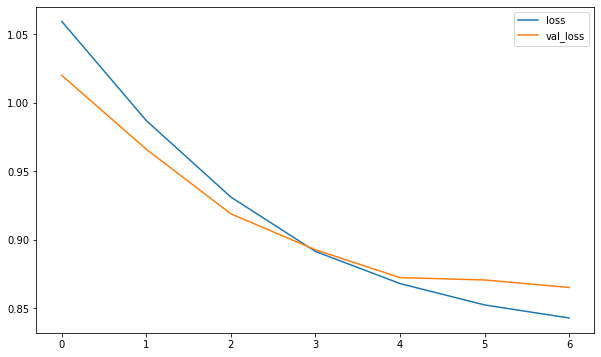

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
# 学習過程のプロット
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.legend()

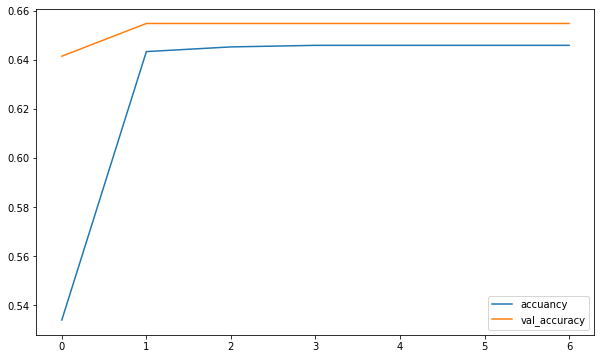

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
# 学習過程のプロット

plt.plot(history.epoch, history.history["accuracy"], label="accuancy")
plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")

plt.legend()

In [78]:
# テストデータを用いた最終的、パフォーマンス計測
score = lstm_model.evaluate(test_x, 
                            test_y,
                            verbose=0
                            )
 
print("testデータでのloss：",score[0]) # lossの表示。
print("testデータでのaccuracy：",score[1]) # accuracyの表示。

testデータでのloss： 0.8599094152450562
testデータでのaccuracy： 0.6573333144187927
